# Viral Tweet Predictor

## Load Library and Scraped Twitter Datasets

Tweets scraped from Fox, CNN, and BBC news stations twitter accounts

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression
import re
import datetime
import time
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt

def clean(txt):
    txt = re.sub(r"https?.*", "", txt)
    txt = re.sub(r"^[A-Z ]*:", "", txt)
    txt = re.sub(r"[^A-Za-z]+", " ", txt)
    return txt.strip()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rudger_dame1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
cnn = pd.read_csv("CNN_tweets.csv", sep='\t')
cnn["cat"] = 1
fox = pd.read_csv("FOX_tweets.csv", sep='\t')
fox["cat"] = 0
bbc = pd.read_csv("BBC_tweets.csv", sep='\t')
bbc["cat"] = 2

data = pd.concat([cnn, fox, bbc])
data2 = data.sample(frac=1)
data = data2[:len(data2)//10]
seconds_in_day = 24*60*60
data.head(2)

C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\770599312.py:1: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  cnn = pd.read_csv("CNN_tweets.csv", sep='\t')
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\770599312.py:3: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  fox = pd.read_csv("FOX_tweets.csv", sep='\t')
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\770599312.py:5: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  bbc = pd.read_csv("BBC_tweets.csv", sep='\t')


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
49642,897791884512440320,897791884512440320,2017-08-16 06:07:20 Mountain Daylight Time,2017-08-16,06:07:20,-600,742143,bbcworld,BBC News (World),NaN,Tears and silence https://t.co/fmOYC2Rs7z,en,[],['http://bbc.in/2i5ezod'],[],37,160,139,[],[],https://twitter.com/BBCWorld/status/897791884512440320,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2
69069,743941941612679169,743941941612679169,2016-06-17 17:02:35 Mountain Daylight Time,2016-06-17,17:02:35,-600,742143,bbcworld,BBC News (World),NaN,"Russian athletes ban is 'unfair', says Vladimir Putin https://t.co/1jEtTf7k3X",en,[],['http://bbc.in/1rtN4E7'],[],43,82,77,[],[],https://twitter.com/BBCWorld/status/743941941612679169,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2


# Clean Data and Create New Features
Added Features:
- time of tweet (ex. year, day, hour, and sec)
- length of tweet
- number of words
- number of capitalized words
- ratio of capitalized words to number of words
- sentiment analysis
- number of hashtags
- if the tweet had a video or thumbnail

In [23]:
timestamps = data["time"].fillna("23:59:59").values
datestamps = data["date"].replace(r"http:.*", "2020-01-01", regex=True).values

data.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
49642,897791884512440320,897791884512440320,2017-08-16 06:07:20 Mountain Daylight Time,2017-08-16,06:07:20,-600,742143,bbcworld,BBC News (World),NaN,Tears and silence https://t.co/fmOYC2Rs7z,en,[],['http://bbc.in/2i5ezod'],[],37,160,139,[],[],https://twitter.com/BBCWorld/status/897791884512440320,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2
69069,743941941612679169,743941941612679169,2016-06-17 17:02:35 Mountain Daylight Time,2016-06-17,17:02:35,-600,742143,bbcworld,BBC News (World),NaN,"Russian athletes ban is 'unfair', says Vladimir Putin https://t.co/1jEtTf7k3X",en,[],['http://bbc.in/1rtN4E7'],[],43,82,77,[],[],https://twitter.com/BBCWorld/status/743941941612679169,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2


In [24]:
data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
data["cos_day"] = [np.cos(i * 2*np.pi) for i in data["day_frac"].values]
data["seconds"] = [int(i.split(":")[2])/60 for i in timestamps]
data["minutes"] = [int(i.split(":")[1])/60 for i in timestamps]
data["hours"] = [int(i.split(":")[0])/24 for i in timestamps]
data["year"] = [int(i.split("-")[0]) for i in datestamps]
data["month"] = [int(i.split("-")[1]) for i in datestamps]
data["day"] = [int(i.split("-")[2]) for i in datestamps]
data["unix_time"] = [time.mktime(datetime.datetime(i[2], i[1], i[0]).timetuple())/1000000000 for i in zip(data.day.values, data.month.values, data.year.values)]
data["cleaned_tweet"] = [clean(txt) for txt in data.tweet.fillna("").values]
data["length"] = [len(i) for i in data["cleaned_tweet"].values]
data["num_words"] = [len(i.split(" ")) for i in data.cleaned_tweet.values]
data["num_caps"] = [len(i) for i in data["cleaned_tweet"].replace(r"[^A-Z]","", regex=True)]
data["cap_word_frac"] = (data["num_caps"] / data["num_words"]).replace(np.inf,-1).replace(np.nan, -2)
data["num_hashtag"] = [len(i.split(",")) if i != '[]' else 0 for i in data['hashtags']]
data["thumbn"] = ~data["thumbnail"].isna()
data["thumbn"] = data["thumbn"].astype(int)
data.head(3)


C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\3680701753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\3680701753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\36807

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat,day_frac,sin_day,cos_day,seconds,minutes,hours,year,month,day,unix_time,cleaned_tweet,length,num_words,num_caps,cap_word_frac,num_hashtag,thumbn
49642,897791884512440320,897791884512440320,2017-08-16 06:07:20 Mountain Daylight Time,2017-08-16,06:07:20,-600,742143,bbcworld,BBC News (World),NaN,Tears and silence https://t.co/fmOYC2Rs7z,en,[],['http://bbc.in/2i5ezod'],[],37,160,139,[],[],https://twitter.com/BBCWorld/status/897791884512440320,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2,0.255093,0.999488,-0.031992,0.333333,0.116667,0.250000,2017,8,16,1.502860,Tears and silence,17,3,1,0.333333,0,0
69069,743941941612679169,743941941612679169,2016-06-17 17:02:35 Mountain Daylight Time,2016-06-17,17:02:35,-600,742143,bbcworld,BBC News (World),NaN,"Russian athletes ban is 'unfair', says Vladimir Putin https://t.co/1jEtTf7k3X",en,[],['http://bbc.in/1rtN4E7'],[],43,82,77,[],[],https://twitter.com/BBCWorld/status/743941941612679169,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2,0.710127,-0.968782,-0.247915,0.583333,0.033333,0.708333,2016,6,17,1.466140,Russian athletes ban is unfair says Vladimir Putin,50,8,3,0.375000,0,0
16399,1317169714364370947,1317169714364370947,2020-10-16 12:25:06 Mountain Daylight Time,2020-10-16,12:25:06,-600,759251,cnn,CNN,NaN,"A man has been found decapitated in a Paris suburb and a suspect was fatally shot by police, France's anti-terror prosecutor says. https://t.co/3bvftyDqw7",en,[],['https://cnn.it/3jc8rVK'],[],571,1402,2896,[],[],https://twitter.com/CNN/status/1317169714364370947,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1,0.517431,-0.109301,-0.994009,0.100000,0.416667,0.500000,2020,10,16,1.602824,A man has been found decapitated in a Paris suburb and a suspect was fatally shot by police France s anti terror prosecutor says,128,24,3,0.125000,0,0


### Sentiment analysis on tweeted text

In [25]:
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(twt) for twt in tqdm(data.cleaned_tweet.values)]
data["neu"] = [d["neu"] for d in sentiments]
data["neg"] = [d["neg"] for d in sentiments]
data["pos"] = [d["pos"] for d in sentiments]
data["com"] = [d["compound"] for d in sentiments]

100%|██████████| 92288/92288 [00:14<00:00, 6545.55it/s]
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\3868843999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neu"] = [d["neu"] for d in sentiments]
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\3868843999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neg"] = [d["neg"] for d in sentiments]
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\3868843999.py:5: SettingWithCopyWarning: 
A value is trying to be 

## Quantify a Viral Tweet 

To quantify how viral a tweet is, we took the natural log of the number of tweets. We expect the viral nature of a tweet to 
increase in popularity at an exponential scale rather than at a linear rate.

In [26]:
data["viral"] = [np.log(i) if i !=0 else 0 for i in data['likes_count'].values]


C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\1813923341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["viral"] = [np.log(i) if i !=0 else 0 for i in data['likes_count'].values]


In [27]:
columns1 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","video","num_hashtag","cat","thumbn"]
columns2 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","video","num_hashtag","cat","thumbn","likes_count","retweets_count","replies_count"]

data_short = data[columns1]
data_corr = data[columns2]


## Count Amount of Common Words

In [28]:
vectorizer = CountVectorizer(stop_words="english", max_df=0.1, max_features=50)
vectorizer.fit(data_short["cleaned_tweet"])
temp_data = vectorizer.transform(data_short["cleaned_tweet"])

In [29]:
df = pd.DataFrame(data=temp_data.toarray(),columns=[f"{i}_vocab" for i in vectorizer.get_feature_names()])
df.describe()


C:\Users\rudger_dame1\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,donald_vocab,election_vocab,going_vocab,government_vocab,health_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,man_vocab,national_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,said_vocab,say_vocab,says_vocab,school_vocab,state_vocab,think_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab
count,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000
mean,0.012548,0.014726,0.016958,0.012721,0.013761,0.011973,0.015040,0.014986,0.015452,0.014346,0.017023,0.013285,0.012342,0.012093,0.013350,0.013198,0.014010,0.011410,0.023578,0.014715,0.017196,0.012634,0.024554,0.011692,0.057743,0.015224,0.014867,0.023687,0.012743,0.015246,0.037329,0.030156,0.019092,0.066661,0.018431,0.016080,0.016849,0.027566,0.059878,0.012038,0.020859,0.011822,0.016795,0.075644,0.011367,0.015332,0.013068,0.023004,0.030394,0.017066
std,0.111701,0.126679,0.139986,0.113414,0.123716,0.112489,0.126685,0.124752,0.127488,0.124610,0.136052,0.116740,0.121615,0.109597,0.119847,0.123164,0.121077,0.110898,0.159734,0.123343,0.131247,0.115600,0.159111,0.111551,0.243353,0.127813,0.123061,0.154756,0.113316,0.125759,0.199537,0.179789,0.137325,0.269883,0.134667,0.130353,0.133745,0.165961,0.241875,0.120572,0.150375,0.113559,0.133143,0.279451,0.110118,0.126864,0.116579,0.154614,0.180050,0.131511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [30]:
new_data = pd.concat([df, data_short.reset_index().drop("index", axis=1)], axis=1)
new_data.head(2)

,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,donald_vocab,election_vocab,going_vocab,government_vocab,health_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,man_vocab,national_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,said_vocab,say_vocab,says_vocab,school_vocab,state_vocab,think_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab,day_frac,neu,neg,pos,com,sin_day,cos_day,seconds,minutes,hours,cleaned_tweet,length,num_words,num_caps,cap_word_frac,video,num_hashtag,cat,thumbn,month,day
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.255093,0.513,0.487,0.0,-0.2263,0.999488,-0.031992,0.333333,0.116667,0.250000,Tears and silence,17,3,1,0.333333,0,0,2,0,8,16
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.710127,0.472,0.528,0.0,-0.7717,-0.968782,-0.247915,0.583333,0.033333,0.708333,Russian athletes ban is unfair says Vladimir Putin,50,8,3,0.375000,0,0,2,0,6,17


## Correlation between the Data's features

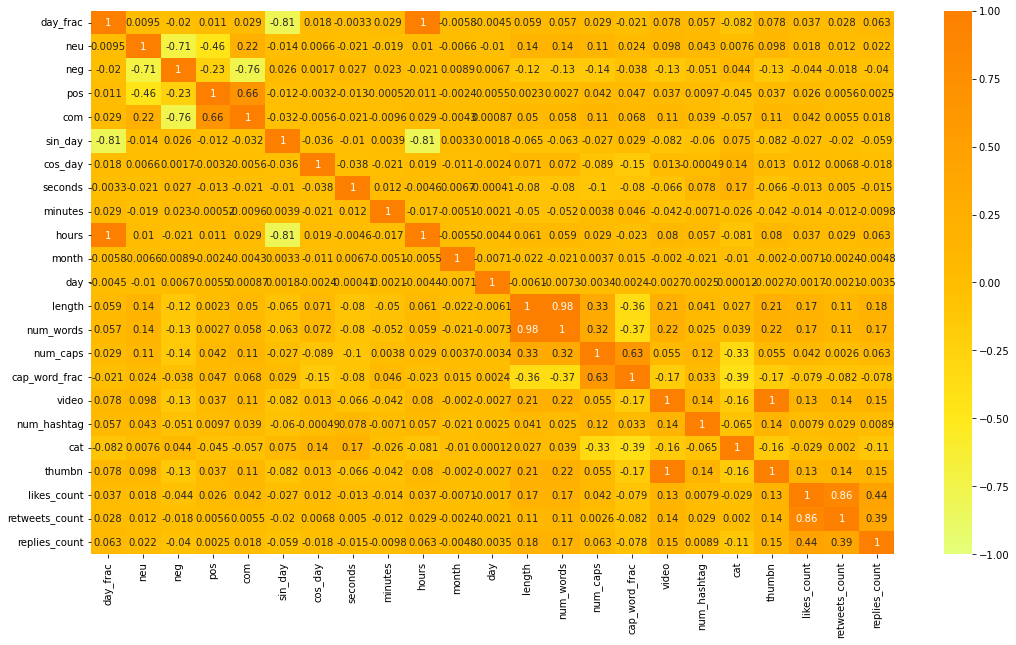

In [31]:
import seaborn as sb
plt.figure(figsize = (18,10))
corr = data_corr.corr()
sb.heatmap(corr, cmap = 'Wistia', vmin=-1, vmax=1,annot= True)
plt.show(sb)

## Slit and Scale Data

In [32]:

del new_data["cleaned_tweet"]
X_train, X_test, y_train, y_test = train_test_split(new_data, data["viral"], test_size=0.2, random_state=42)


In [33]:
rc = RobustScaler()
X_train = rc.fit_transform(X_train.astype(np.float))
X_test= rc.transform(X_test.astype(np.float))

C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\2028186727.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = rc.fit_transform(X_train.astype(np.float))
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\2028186727.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= rc.transform(X_test.astype(np.float))

## Linear, RandomForest and Multi-layer Perceptron Regressions

The RandomForest regression seems to have them best fit.

In [34]:

lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#print score
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))


lr.coef_: [ 5.63911083e-01  1.93970600e-01  1.65182219e-01  1.43490238e-01
 -1.83219617e-01  1.44418261e-01  4.10437814e-01  1.46560014e+00
  1.79954388e-01 -3.32316234e-01 -6.47342468e-03  6.01527607e-02
  2.22103976e-01  1.56400264e-01  1.65018788e-01  9.50287936e-02
 -8.04497436e-01 -9.05719834e-02 -2.77061143e-02  2.99493542e-01
 -1.76113154e-01  2.52990273e-01 -4.25050444e-02  3.93381576e-01
  1.02611877e-01  3.24375397e-01  6.84816464e-02 -2.07780236e-01
 -2.74563141e-01  3.90016020e-01 -7.36872262e-02 -9.82076767e-02
  1.69668637e+00 -1.05716496e-01  1.07814479e+00 -2.51065660e-01
  3.85662673e-01 -2.04627304e-01 -1.27050173e-01  3.71234549e-01
  1.42118278e-01 -1.97192375e-01  2.59553458e-01  1.16304211e+00
  4.77650856e-02  2.70478665e-01  1.72947589e-01  1.95110709e-01
  2.79150166e-02  2.51904130e-01 -1.50037832e+12 -7.07709837e-01
 -5.56581715e-01 -3.03006734e-01  3.40289880e-02 -1.59317656e-01
  1.42546612e-01  1.23894110e+09  7.43364658e+10  1.48672932e+12
  1.06406243e+0

In [36]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000)

#fit model
regr.fit(X_train,y_train.values.ravel())
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

#print score
print('Multi-layer Perceptron train score %.3f, Multi-layer Perceptron test score: %.3f' % (
regr.score(X_train,y_train),
regr.score(X_test, y_test)))

Multi-layer Perceptron train score 0.791, Multi-layer Perceptron test score: 0.746


In [ ]:

forest = RFR(n_estimators=1000,
                     max_depth=20,
                     min_samples_split=2,
                     min_samples_leaf= 1,
                     bootstrap=True,
                     oob_score=False)

#fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

#print score
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))


### Feature Importances

In [ ]:
importance = pd.DataFrame({"Importance":forest.feature_importances_, "name": list(new_data.columns)}).sort_values("Importance", ascending=False)
importance

### Random Forest Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV
#Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))
    print()



###Random Forest parameter grid###
param_grid_rf = dict(n_estimators=[100, 1000],
                     max_depth=[2, 20, 40],
                     min_samples_split=[2],
                     min_samples_leaf= np.arange(1, 30, 10, int),
                     bootstrap=[True, False],
                     oob_score=[False, ])


forest = GridSearchCV(RFR(random_state=0), param_grid=param_grid_rf, cv=2, verbose=3)

#fit model
forest.fit(X_train,y_train.values.ravel())


#print score
print('\n\nforest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))

print_best_params(forest)


Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.6s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.7s
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.444 total time= 6.1min
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.485 total time= 6.1min
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.4s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.4s
[CV 1/2] END bootstrap=True, max_de

[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.709 total time=44.5min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.714 total time=43.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.731 total time= 4.3min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.730 total time= 4.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.731 total time=43.1min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.730 total time=40.5min
[CV 1/2] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_sp